# Run this code block to install dependencies

In [1]:
# !git clone https://github.com/KenzaB27/TransUnet.git
# %cd TransUnet
# !pip install -r requirements.txt 
# %cd ..

In [20]:
%cd TransUnet
import models.transunet as transunet
import utils.visualize as visualize
import experiments.config as conf
import importlib
%cd ..

/Users/srinathramalingam/Desktop/codebase/TransUnet/TransUnet
/Users/srinathramalingam/Desktop/codebase/TransUnet


In [2]:
import os
import cv2
import pickle
import imageio
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from bp import Environment, String
from focal_loss import BinaryFocalLoss
from dTurk.generators import SemsegData
from dTurk.builders import model_builder
from tensorflow.keras import backend as K
from dTurk.utils.clr_callback import CyclicLR
from dTurk.metrics import MeanIoU, WeightedMeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint
from dTurk.loaders.dataset_loader import SemsegDatasetLoader
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from dTurk.augmentation.transforms import get_train_transform_policy, get_validation_transform_policy
from dTurk.models.sm_models.losses import CategoricalCELoss, CategoricalFocalLoss, DiceLoss, JaccardLoss

Segmentation Models: using `tf.keras` framework.


In [3]:
import os
import argparse
import pandas as pd
import tensorflow as tf
from bp import Environment
import TransUnet.experiments.config as conf
from dTurk.utils.clr_callback import CyclicLR
import TransUnet.models.transunet as transunet
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from train_helpers import dice_loss, mean_iou, oversampling, create_dataset

In [4]:
import masterful
masterful = masterful.register()

/bin/sh: nvidia-smi: command not found


Loaded Masterful version 0.5.0. This software is distributed free of charge for
personal use. Register in the next 45 days to continue using Masterful.
Visit http://www.masterfulai.com/register for more details.



In [5]:
env = Environment()

config = conf.get_transunet()
config['image_size'] = 256
config["filters"] = 3
config['n_skip'] = 3
config['decoder_channels'] = [128, 64, 32, 16]
config['resnet']['n_layers'] = (3,4,9,12)
config['dropout'] = 0.1
config['grid'] = (28,28)
config["n_layers"] = 12

In [6]:
dataset = "MACH-77-it1"
machine = "local"
monitor = "val_loss"
epochs = 5
patience = 12
batch_size = 32
lr = 0.005
train_augmentation_file = "/Users/srinathramalingam/Desktop/codebase/dTurk/dTurk/augmentation/configs/light.yaml"
save_path = "weights/TU1"
checkpoint_filepath = save_path + "/checkpoint/"

In [7]:
dataset_directory = os.environ.get("BP_PATH_REMOTE") + "/datasets/semseg_base" + "/" + dataset

In [8]:
try:
    gpus = tf.config.list_physical_devices("GPU")
    tf.config.set_visible_devices(gpus[args_dict["gpu"]], "GPU")
except:
    print("Gpus not found")

Gpus not found


In [9]:
train_input_names = [
    dataset_directory + "/train/" + i
    for i in os.listdir(dataset_directory + "/train/")
    if i.endswith(".png")
]
train_label_names = [
    dataset_directory + "/train_labels/" + i
    for i in os.listdir(dataset_directory + "/train/")
    if i.endswith(".png")
]
val_input_names = [
    dataset_directory + "/val/" + i for i in os.listdir(dataset_directory + "/val/") if i.endswith(".png")
]
val_label_names = [
    dataset_directory + "/val_labels/" + i for i in os.listdir(dataset_directory + "/val/") if i.endswith(".png")
]

In [10]:
train_ds_batched, val_ds_batched = create_dataset(train_input_names, val_input_names, train_augmentation=train_augmentation_file)

100%|██████████████████████████████████████| 3000/3000 [00:07<00:00, 379.30it/s]
/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [13]:
import matplotlib.pyplot as plt

In [21]:
x_train = []
y_train = []
for i in range(10):
    img = plt.imread(train_input_names[i])
    mask = plt.imread(train_label_names[i])
    x_train.append(img)
    y_train.append(mask)

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train)))

In [23]:
step_size = int(2.0 * len(train_input_names) / batch_size)

In [24]:
network = transunet.TransUnet(config, trainable=False)

ListWrapper([128, 64, 32, 16])


In [25]:
network.model.compile(optimizer="adam", loss=dice_loss, metrics=mean_iou)

In [26]:
callbacks = []
cyclic_lr = CyclicLR(
    base_lr=lr / 10.0,
    max_lr=lr,
    step_size=step_size,
    mode="triangular2",
    cyclic_momentum=False,
    max_momentum=False,
    base_momentum=0.8,
)
callbacks.append(cyclic_lr)

early_stopping = EarlyStopping(
    monitor=monitor,
    mode="min" if "loss" in monitor else "max",
    patience=patience,
    verbose=1,
    restore_best_weights=True,
)
callbacks.append(early_stopping)

In [27]:
model_params = masterful.architecture.learn_architecture_params(
  model=network.model,
  task=masterful.enums.Task.SEMANTIC_SEGMENTATION,
  input_range=masterful.enums.ImageRange.ZERO_ONE,
  num_classes=3,
  prediction_logits=True,
)
training_dataset_params = masterful.data.learn_data_params(
  dataset=dataset,
  task=masterful.enums.Task.SEMANTIC_SEGMENTATION,
  image_range=masterful.enums.ImageRange.ZERO_ONE,
  num_classes=3,
  sparse_labels=False,
)

In [28]:
optimization_params = masterful.optimization.learn_optimization_params(
  network.model,
  model_params,
  dataset,
  training_dataset_params,
)

regularization_params = masterful.regularization.learn_regularization_params(
  network.model,
  model_params,
  optimization_params,
  dataset,
  training_dataset_params,
)

Callbacks: 100%|██████████████████████████████| 5/5 [00:00<00:00, 347.70steps/s]
MASTERFUL [16:39:29]: Meta-Learning Regularization Parameters...
MASTERFUL [16:39:33]: Warming up model for analysis.
MASTERFUL [16:39:33]: 	Warming up batch norm statistics (this could take a few minutes).
MASTERFUL [16:39:44]: 	Warming up training for 45 steps.
100%|████████████████████████████████████████| 45/45 [01:29<00:00,  1.98s/steps]
MASTERFUL [16:41:13]: 	Validating batch norm statistics after warmup for stability (this could take a few minutes).
MASTERFUL [16:41:32]: Analyzing baseline model performance. Training until validation loss stabilizes...
Baseline Training: 100%|███████████████| 3490/3490 [1:07:56<00:00,  1.17s/steps]
MASTERFUL [17:49:50]: Baseline training complete.
MASTERFUL [17:49:50]: Meta-Learning Basic Data Augmentations...
Node 4/4: 100%|████████████████████████████| 200/200 [03:43<00:00,  1.12s/steps]
MASTERFUL [18:05:51]: Meta-Learning Data Augmentation Clusters...
Node 10/10:

In [ ]:
ssl_params = masterful.ssl.learn_ssl_params(
  dataset,
  training_dataset_params,
)

In [ ]:
training_report = masterful.training.train(
  network.model,
  model_params,
  optimization_params,
  regularization_params,
  ssl_params,
  training_dataset,
  training_dataset_params,
)

In [46]:
history = network.model.fit(
    train, epochs=epochs, callbacks=[callbacks]
)

Epoch 1/5


ValueError: in user code:

    File "/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/keras/engine/input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "TransUNet" (type Functional).
    
    Input 0 of layer "conv1_pad" is incompatible with the layer: expected ndim=4, found ndim=0. Full shape received: ()
    
    Call arguments received by layer "TransUNet" (type Functional):
      • inputs=tf.Tensor(shape=(), dtype=string)
      • training=True
      • mask=None


In [16]:
iou = history.history["mean_iou"]
val_iou = history.history["val_mean_iou"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

df = pd.DataFrame(iou)
df.columns = ["mean_iou"]
df["val_mean_iou"] = val_iou
df["loss"] = loss
df["val_loss"] = val_loss

df.to_csv("TU1-logs.csv")

In [17]:
network.model.load_weights(checkpoint_filepath)
saved_model_path = save_path + "/model"
network.model.save(saved_model_path)

2022-06-30 07:53:00.018976: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open weights/TU1/checkpoint/: FAILED_PRECONDITION: weights/TU1/checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


IsADirectoryError: [Errno 21] Unable to open file (file read failed: time = Thu Jun 30 07:53:00 2022
, filename = 'weights/TU1/checkpoint/', file descriptor = 82, errno = 21, error message = 'Is a directory', buf = 0x7ff7bb3be1b8, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

In [19]:
import cv2
import dTurk.models.sm_models as sm
from dTurk.models.SM_UNet import SM_UNet_Builder

builder = SM_UNet_Builder(
    encoder_name='efficientnetv2-l',
    input_shape=(256, 256, 3),
    num_classes=3,
    activation="softmax",
    train_encoder=False,
    encoder_weights="imagenet",
    decoder_block_type="upsampling",
    head_dropout=0,  # dropout at head
    dropout=0,  # dropout at feature extraction
)
model2 = builder.build_model()
model2.load_weights("/Users/srinathramalingam/Desktop/codebase/TransUnet/weights/Unet/checkpoint/Unet.h5")

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [23]:
def predict(image, model, file):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.array(img)/255
    img = img.reshape((1,256,256,3))
    prediction = model.predict(img)
    prediction = tf.clip_by_value(prediction, 0.0, 1.0)
    pred = prediction * 255
    pred = np.array(prediction).reshape((256,256,3))
    img = img.reshape((256,256,3))
    return img, pred

In [29]:
val_input_names = ["/Users/srinathramalingam/Desktop/codebase/Jupyter_predictions_Nearspace/MACH-77-it2/train/images/" + i for i in os.listdir("/Users/srinathramalingam/Desktop/codebase/Jupyter_predictions_Nearspace/MACH-77-it2/train/images") if i.endswith(".png")]

1/1 [==============================] - 0s 414ms/step


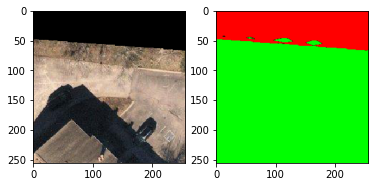

1/1 [==============================] - 0s 403ms/step


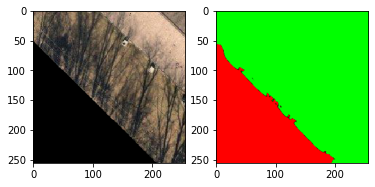

1/1 [==============================] - 0s 391ms/step


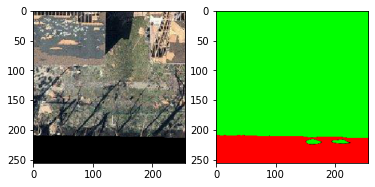

1/1 [==============================] - 0s 341ms/step


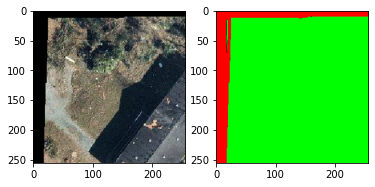

1/1 [==============================] - 0s 329ms/step


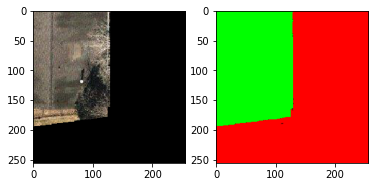

1/1 [==============================] - 0s 401ms/step


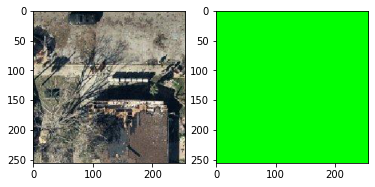

1/1 [==============================] - 0s 393ms/step


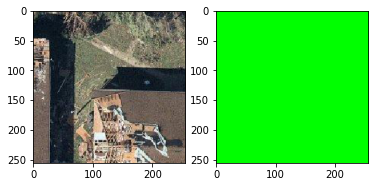

1/1 [==============================] - 0s 380ms/step


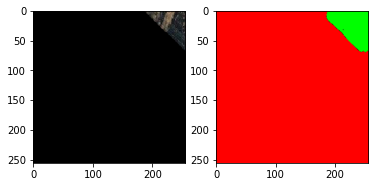

1/1 [==============================] - 0s 385ms/step


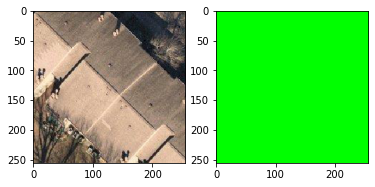

1/1 [==============================] - 0s 350ms/step


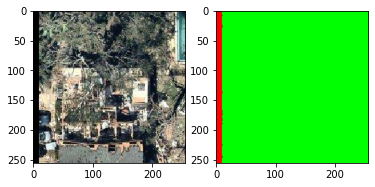

1/1 [==============================] - 0s 331ms/step


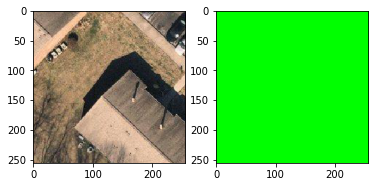

1/1 [==============================] - 0s 366ms/step


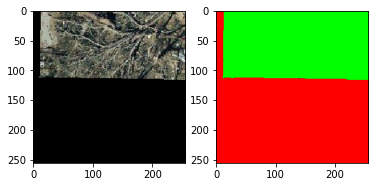

1/1 [==============================] - 0s 395ms/step


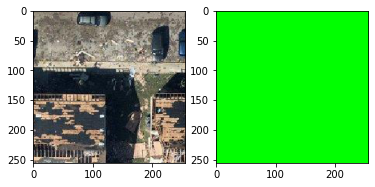

1/1 [==============================] - 0s 388ms/step


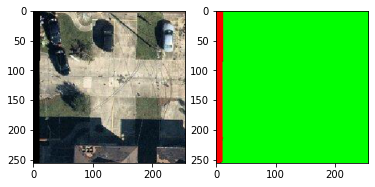

1/1 [==============================] - 0s 400ms/step


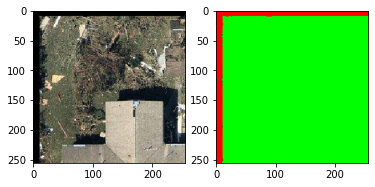

1/1 [==============================] - 0s 399ms/step


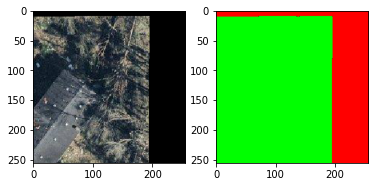

1/1 [==============================] - 0s 381ms/step


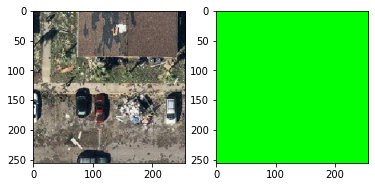

1/1 [==============================] - 0s 364ms/step


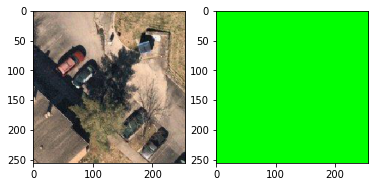

1/1 [==============================] - 0s 374ms/step


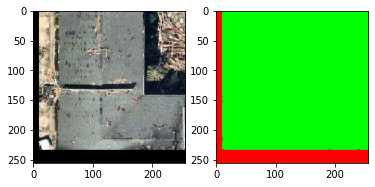

1/1 [==============================] - 0s 374ms/step


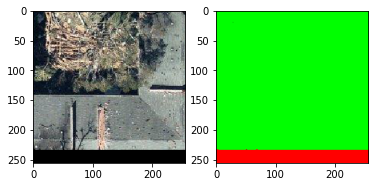

1/1 [==============================] - 0s 400ms/step


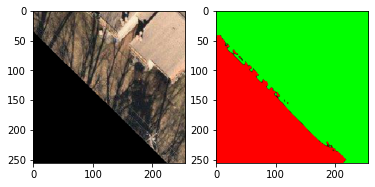

1/1 [==============================] - 0s 387ms/step


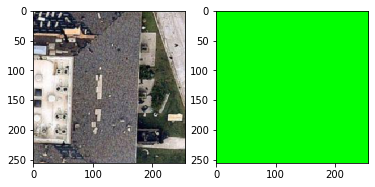

1/1 [==============================] - 0s 360ms/step


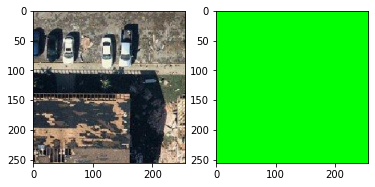

1/1 [==============================] - 0s 373ms/step


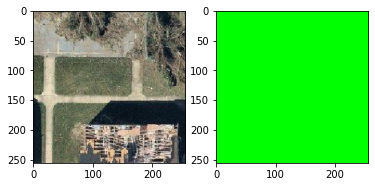

1/1 [==============================] - 0s 380ms/step


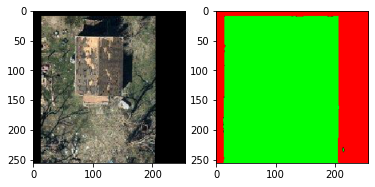

1/1 [==============================] - 0s 386ms/step


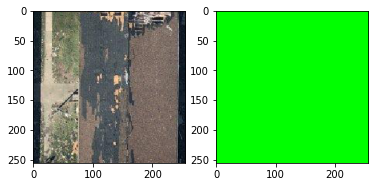

1/1 [==============================] - 0s 373ms/step


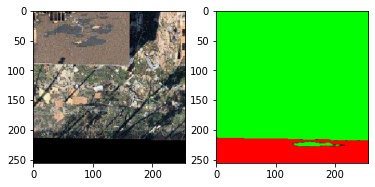

1/1 [==============================] - 0s 391ms/step


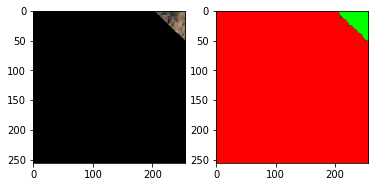

1/1 [==============================] - 0s 400ms/step


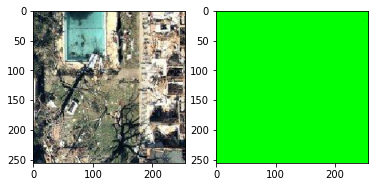

1/1 [==============================] - 0s 377ms/step


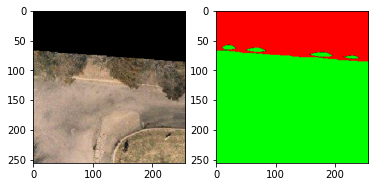

1/1 [==============================] - 0s 396ms/step


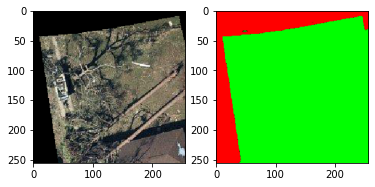

1/1 [==============================] - 0s 396ms/step


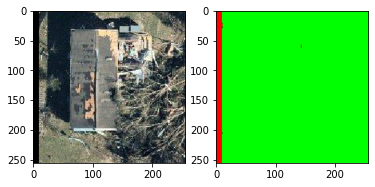

1/1 [==============================] - 0s 404ms/step


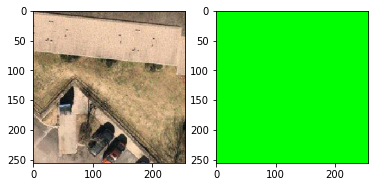

1/1 [==============================] - 0s 379ms/step


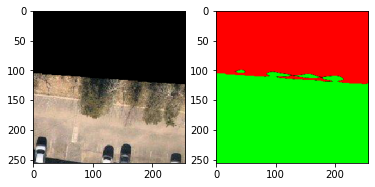

1/1 [==============================] - 0s 396ms/step


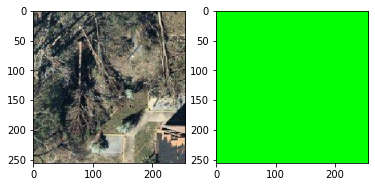

1/1 [==============================] - 0s 338ms/step


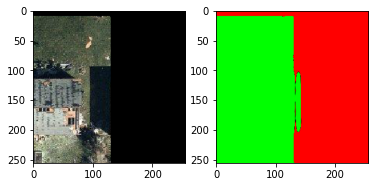

1/1 [==============================] - 0s 338ms/step


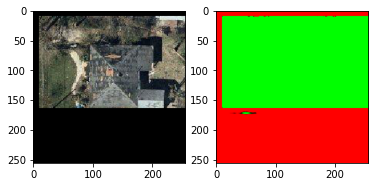

1/1 [==============================] - 0s 341ms/step


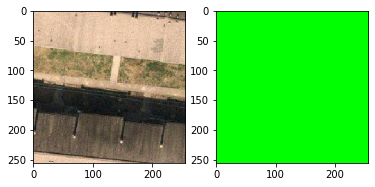

1/1 [==============================] - 0s 344ms/step


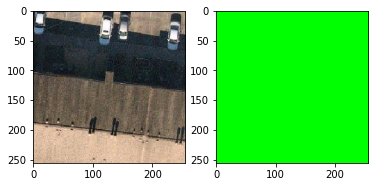

1/1 [==============================] - 0s 357ms/step


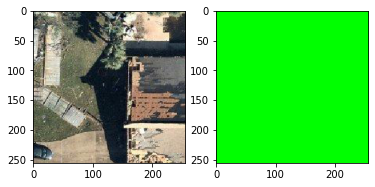

1/1 [==============================] - 0s 362ms/step


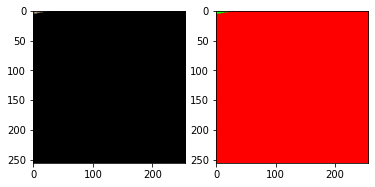

1/1 [==============================] - 0s 356ms/step


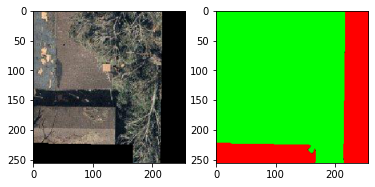

1/1 [==============================] - 0s 344ms/step


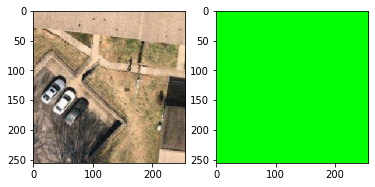

1/1 [==============================] - 0s 351ms/step


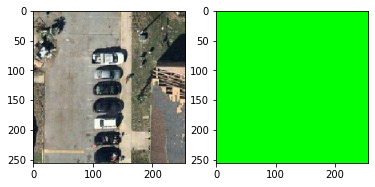

1/1 [==============================] - 0s 355ms/step


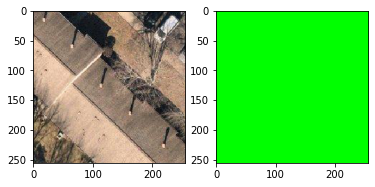

1/1 [==============================] - 0s 354ms/step


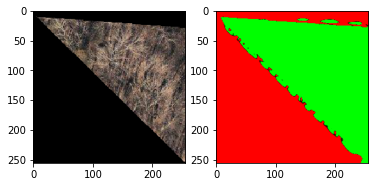

1/1 [==============================] - 0s 349ms/step


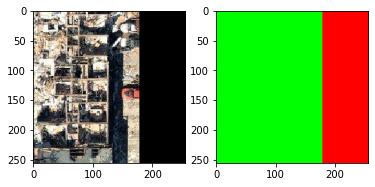

1/1 [==============================] - 0s 357ms/step


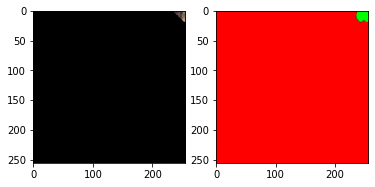

1/1 [==============================] - 0s 357ms/step


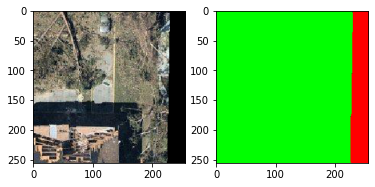

1/1 [==============================] - 0s 398ms/step


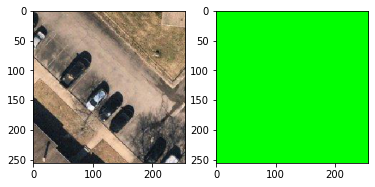

1/1 [==============================] - 0s 391ms/step


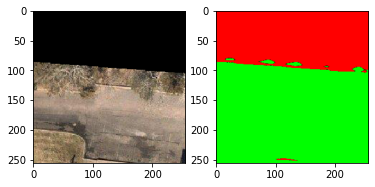

1/1 [==============================] - 0s 379ms/step


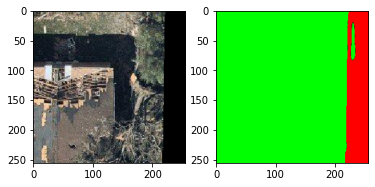

1/1 [==============================] - 0s 377ms/step


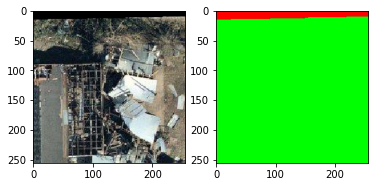

1/1 [==============================] - 0s 394ms/step


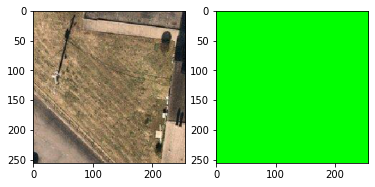

1/1 [==============================] - 0s 389ms/step


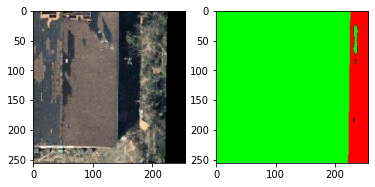

1/1 [==============================] - 0s 358ms/step


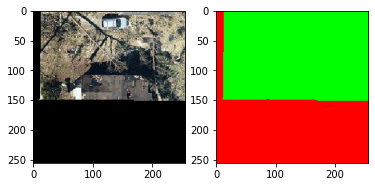

1/1 [==============================] - 0s 369ms/step


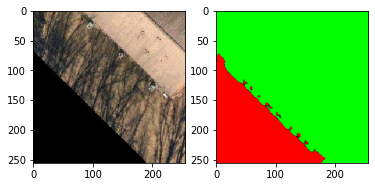

1/1 [==============================] - 0s 393ms/step


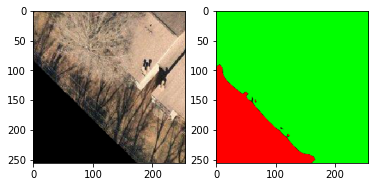

1/1 [==============================] - 0s 405ms/step


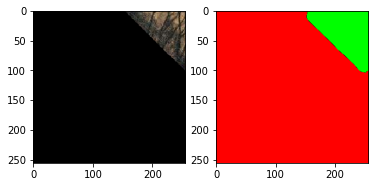

1/1 [==============================] - 0s 383ms/step


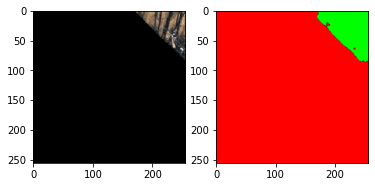

1/1 [==============================] - 0s 375ms/step


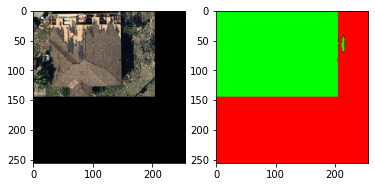

1/1 [==============================] - 0s 368ms/step


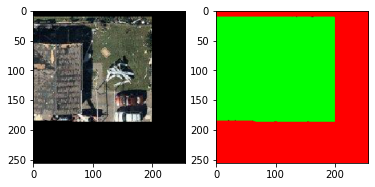

1/1 [==============================] - 0s 380ms/step


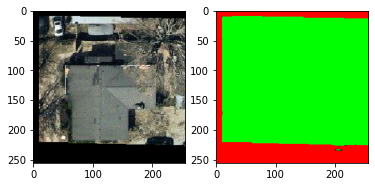

1/1 [==============================] - 0s 377ms/step


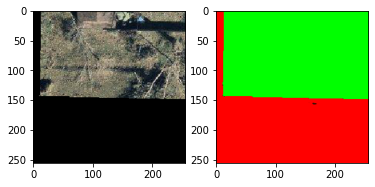

1/1 [==============================] - 0s 369ms/step


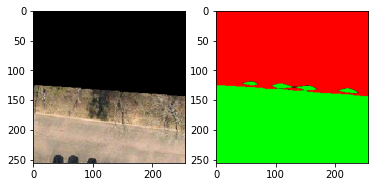

1/1 [==============================] - 0s 382ms/step


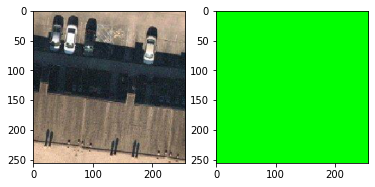

1/1 [==============================] - 0s 378ms/step


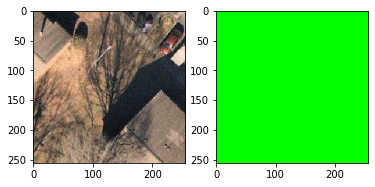

1/1 [==============================] - 0s 373ms/step


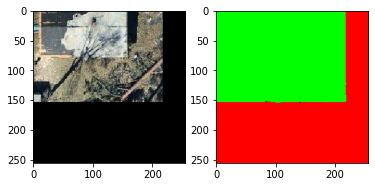

1/1 [==============================] - 0s 360ms/step


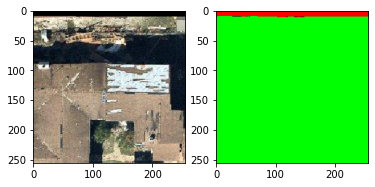

1/1 [==============================] - 0s 366ms/step


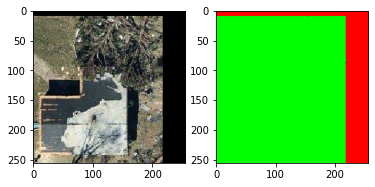

1/1 [==============================] - 0s 369ms/step


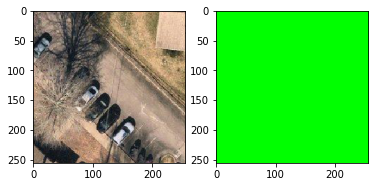

1/1 [==============================] - 0s 385ms/step


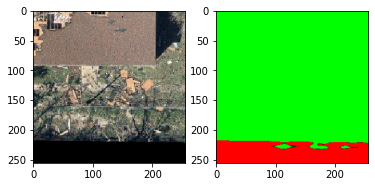

1/1 [==============================] - 0s 410ms/step


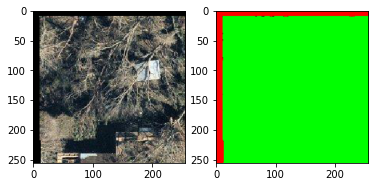

1/1 [==============================] - 0s 377ms/step


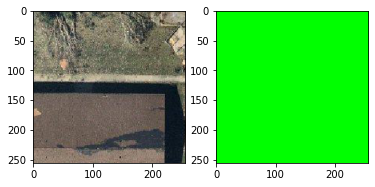

1/1 [==============================] - 0s 371ms/step


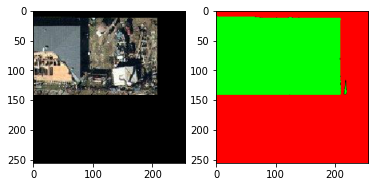

1/1 [==============================] - 0s 374ms/step


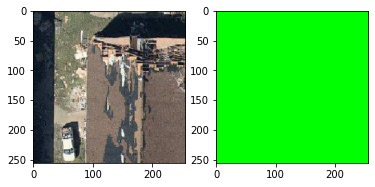

1/1 [==============================] - 0s 381ms/step


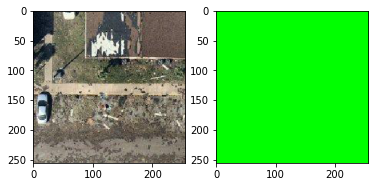

1/1 [==============================] - 0s 376ms/step


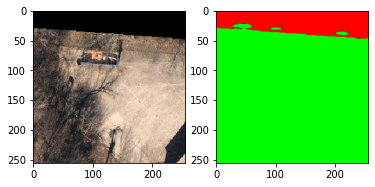

1/1 [==============================] - 0s 365ms/step


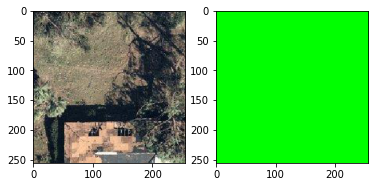

1/1 [==============================] - 0s 370ms/step


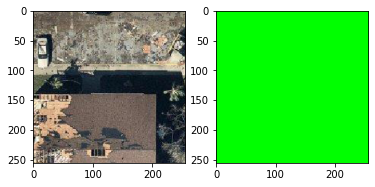

1/1 [==============================] - 0s 369ms/step


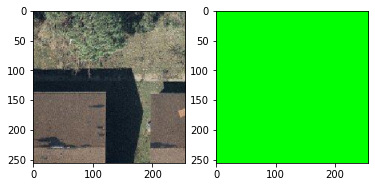

1/1 [==============================] - 0s 380ms/step


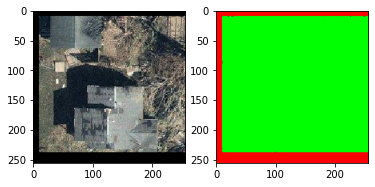

1/1 [==============================] - 0s 375ms/step


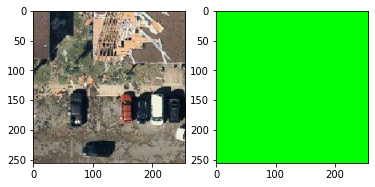

1/1 [==============================] - 0s 366ms/step


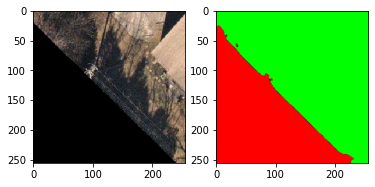

1/1 [==============================] - 0s 376ms/step


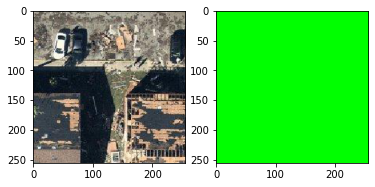

1/1 [==============================] - 0s 381ms/step


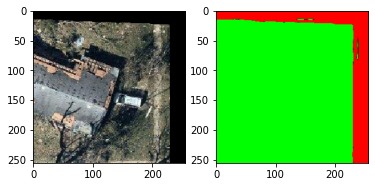

1/1 [==============================] - 0s 386ms/step


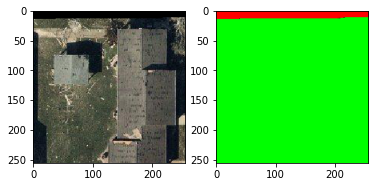

1/1 [==============================] - 0s 382ms/step


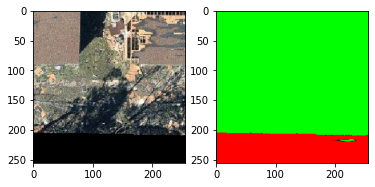

1/1 [==============================] - 0s 379ms/step


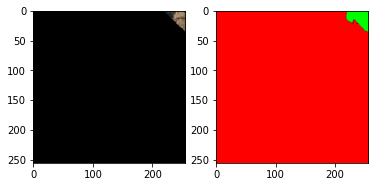

1/1 [==============================] - 0s 380ms/step


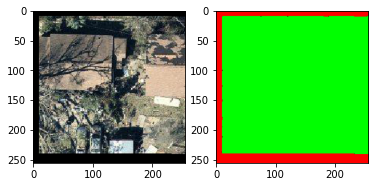

In [30]:
for file in range(len(val_input_names)):
    img, pred = predict(val_input_names[file], network.model, file)
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(pred)

    plt.show()